## Compare results from replication analysis against the discovery data

- compare the replication frontal cortex broad cell-type results against the discovery non-region specific broad cell-types and the discovery region specific broad cell-types
- use regression to model the effect coeffecients and score between the replication and discovery

In [1]:
!date

Fri Jan  5 19:43:32 UTC 2024


#### import libraries

In [127]:
from pandas import read_csv, DataFrame, concat
from numpy import corrcoef
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

#### set notebook variables

In [66]:
# parameters
project = 'aging_phase1'
set_name = f'{project}_replication'
cohort = 'aging'

# directories for initial setup
wrk_dir = '/home/jupyter/brain_aging_phase1'
results_dir = f'{wrk_dir}/results'
replication_dir = f'{wrk_dir}/replication'

# in files
discovery_results_file = f'{results_dir}/{cohort}.glmmtmb_age_diffs.csv'
replication_results_file = f'{replication_dir}/{set_name}.glmmtmb_age_diffs.csv'

# out files


# constants
DEBUG = True
DISC_REGIONS = ['Entorhinal cortex', 'Middle temporal gyrus', 
                'Putamen', 'Subventricular zone']
DISC_CELLTYPES=['Astrocyte', 'Endothelial', 'Ependymal', 'ExN', 'InN', 
                'Microglia', 'Mural', 'Oligodendrocyte', 'OPC', 'SPN']
REP_REGION = 'Frontal cortex'
cell_abbr_mappings = {'ExN': 'ExN', 'Oligodendrocyte': 'Oligo', 'Astrocyte': 'Astro', 
                      'InN': 'InN', 'OPC': 'OPC', 'Microglia': 'Micro', 'Endothelial': 'Endo'}


sns.set_theme(style='white', palette='Paired', font_scale=1.2)

### load the results

#### load the discovery results

In [4]:
disc_df = read_csv(discovery_results_file)
print(f'shape of discovery results {disc_df.shape}')
if DEBUG:
    display(disc_df.sample(5))

shape of discovery results (387117, 9)


,feature,intercept,estimate,std.error,statistic,p.value,tissue,type,fdr_bh
273817,LINC00632,1.386703,0.033813,0.015559,2.173271,0.029760,ExN RORB THEMIS,specific_celltype,0.119989
263163,ZNF436,-1.399331,-0.309023,0.142015,-2.175983,0.029556,ExN RORB THEMIS,specific_celltype,0.119548
252373,ZFAND5,0.158225,0.054038,0.086211,0.626813,0.530782,Astrocyte,specific_celltype,0.659146
192881,LRRC4C,1.796209,0.012293,0.019568,0.628244,0.529844,Entorhinal cortex OPC,region_broad_celltype,0.658378
378285,ZNF528,-0.286193,-0.034849,0.056422,-0.617654,0.536803,SPN D2,specific_celltype,0.664393


##### what type of analysis results are present

In [5]:
for result_type in disc_df.type.unique():
    print(result_type)
    print(disc_df.loc[disc_df.type == result_type].tissue.unique())

broad_celltype
['ExN' 'Oligodendrocyte' 'Astrocyte' 'InN' 'OPC' 'Mural' 'Microglia' 'SPN'
 'Endothelial' 'Ependymal']
region_broad_celltype
['Middle temporal gyrus ExN' 'Middle temporal gyrus Oligodendrocyte'
 'Middle temporal gyrus Astrocyte' 'Middle temporal gyrus InN'
 'Middle temporal gyrus OPC' 'Middle temporal gyrus Mural'
 'Middle temporal gyrus Microglia' 'Middle temporal gyrus SPN'
 'Middle temporal gyrus Endothelial' 'Putamen Oligodendrocyte'
 'Putamen Astrocyte' 'Putamen InN' 'Putamen OPC' 'Putamen Mural'
 'Putamen Microglia' 'Putamen SPN' 'Putamen Endothelial'
 'Entorhinal cortex ExN' 'Entorhinal cortex Oligodendrocyte'
 'Entorhinal cortex Astrocyte' 'Entorhinal cortex InN'
 'Entorhinal cortex OPC' 'Entorhinal cortex Mural'
 'Entorhinal cortex Microglia' 'Entorhinal cortex SPN'
 'Entorhinal cortex Endothelial' 'Entorhinal cortex Ependymal'
 'Subventricular zone ExN' 'Subventricular zone Oligodendrocyte'
 'Subventricular zone Astrocyte' 'Subventricular zone InN'
 'Subventric

##### drop the cluster specific cell-types from discovery result
the replication only used broad cell-types

In [6]:
disc_df = disc_df.loc[disc_df.type != 'specific_celltype']
print(f'new shape of discovery results {disc_df.shape}')
if DEBUG:
    display(disc_df.sample(5))
display(disc_df.type.value_counts())    

new shape of discovery results (229545, 9)


,feature,intercept,estimate,std.error,statistic,p.value,tissue,type,fdr_bh
19539,AL391839.1,-3.405655,-0.188028,0.098534,-1.908253,0.056359,Oligodendrocyte,broad_celltype,0.166510
191403,AC055733.2,-1.632294,-0.509276,0.174707,-2.915028,0.003557,Entorhinal cortex OPC,region_broad_celltype,0.040533
185623,PSME2,-2.217258,-0.344361,0.156017,-2.207210,0.027299,Entorhinal cortex InN,region_broad_celltype,0.114830
144227,AC089985.1,-2.445285,-0.026482,0.188809,-0.140255,0.888458,Putamen SPN,region_broad_celltype,0.942407
167111,GABARAPL1,-1.236166,-0.167791,0.079003,-2.123851,0.033683,Entorhinal cortex Oligodendrocyte,region_broad_celltype,0.127725


region_broad_celltype    153807
broad_celltype            75738
Name: type, dtype: int64

#### load the replication results

In [7]:
rep_df = read_csv(replication_results_file)
print(f'shape of replication results {rep_df.shape}')
if DEBUG:
    display(rep_df.sample(5))

shape of replication results (56736, 9)


,feature,intercept,estimate,std.error,statistic,p.value,tissue,type,fdr_bh
12830,CHMP5,-1.768303,-0.423620,0.179106,-2.365192,0.018021,Frontal cortex InN,region_broad_celltype,0.240119
29577,USP43,-5.846700,0.315541,0.352503,0.895143,0.370710,Frontal cortex Oligo,region_broad_celltype,0.734727
28488,PGP,-2.217341,-0.402770,0.381430,-1.055949,0.290992,Frontal cortex Oligo,region_broad_celltype,0.679919
15114,RFPL2,-3.157297,0.065601,0.319526,0.205308,0.837331,Frontal cortex InN,region_broad_celltype,0.953965
16361,MAOA,-3.082491,-0.176938,0.164621,-1.074818,0.282456,Frontal cortex InN,region_broad_celltype,0.673474


##### what type of analysis results are present

In [8]:
for result_type in rep_df.type.unique():
    print(result_type)
    print(rep_df.loc[rep_df.type == result_type].tissue.unique())

region_broad_celltype
['Frontal cortex Astro' 'Frontal cortex InN' 'Frontal cortex Oligo'
 'Frontal cortex ExN' 'Frontal cortex Micro' 'Frontal cortex OPC'
 'Frontal cortex Endo']


### check all replication and discovary tissue pairings by FDR

In [9]:
fdr_intersects = []
for disc_tissue in disc_df.tissue.unique():
    disc_tissue_sig = disc_df.loc[(disc_df.tissue == disc_tissue) & (disc_df.fdr_bh < 0.05)]
    for rep_tissue in rep_df.tissue.unique():
        rep_tissue_sig = rep_df.loc[(rep_df.tissue == rep_tissue) & (rep_df.fdr_bh < 0.05)]
        shared_cnt = len(set(disc_tissue_sig.feature) & set(rep_tissue_sig.feature))
        percent_shared = (shared_cnt/disc_tissue_sig.shape[0])*100
        # if DEBUG:
        #     print(f'{disc_tissue} : {rep_tissue} = {percent_shared:.3f}%')
        fdr_intersects.append((disc_tissue, rep_tissue, percent_shared))
fdr_results_df = DataFrame(fdr_intersects, columns=['discover', 'replication', 'percent'])
print(f'shape of FDR intersects data frame is {fdr_results_df.shape}')
if DEBUG:
    print(f'fdr instersects has {len(fdr_intersects)} items')
    display(fdr_intersects[:5])    
    display(fdr_results_df.head())
    display(fdr_results_df.sort_values('percent', ascending=False).head(20))

shape of FDR intersects data frame is (329, 3)
fdr instersects has 329 items


[('ExN', 'Frontal cortex Astro', 0.3629764065335753),
 ('ExN', 'Frontal cortex InN', 1.5426497277676952),
 ('ExN', 'Frontal cortex Oligo', 0.8166969147005444),
 ('ExN', 'Frontal cortex ExN', 1.8148820326678767),
 ('ExN', 'Frontal cortex Micro', 0.27223230490018147)]

,discover,replication,percent
0,ExN,Frontal cortex Astro,0.362976
1,ExN,Frontal cortex InN,1.542650
2,ExN,Frontal cortex Oligo,0.816697
3,ExN,Frontal cortex ExN,1.814882
4,ExN,Frontal cortex Micro,0.272232


,discover,replication,percent
183,Putamen Endothelial,Frontal cortex InN,33.333333
188,Putamen Endothelial,Frontal cortex Endo,33.333333
261,Subventricular zone ExN,Frontal cortex Oligo,22.222222
299,Subventricular zone Mural,Frontal cortex OPC,15.384615
162,Putamen Mural,Frontal cortex InN,11.111111
260,Subventricular zone ExN,Frontal cortex InN,11.111111
264,Subventricular zone ExN,Frontal cortex OPC,11.111111
292,Subventricular zone OPC,Frontal cortex OPC,10.041841
110,Middle temporal gyrus Mural,Frontal cortex OPC,10.000000
103,Middle temporal gyrus OPC,Frontal cortex OPC,9.150327


### reformat results for running regressions

In [159]:
def metric_pivot_df(df: DataFrame, metric: str, verbose: bool=False) -> DataFrame:
    ret_df = df.pivot(index='tissue', columns='feature', values=metric)
    print(f'shape of coefficients dataframe {ret_df.shape}')
    if verbose:
        display(ret_df.head())    
    return ret_df

def combine_metric_pivot_df(df1: DataFrame, df2: DataFrame, metric: str, 
                            fill_value: int=0, verbose: bool=False) -> DataFrame:
    m_df1 = metric_pivot_df(df1, metric)
    m_df2  = metric_pivot_df(df2, metric)
    ret_df = concat([m_df1, m_df2])
    # is coefficient is missing, assume no effect and set to fill_value
    ret_df = ret_df.fillna(fill_value)        
    print(f'shape of coefficients dataframe for combined {ret_df.shape}')
    if verbose:
        display(coef_df.head())
    return ret_df

In [160]:
# fill missing p-values with non-significance, ie 1
pvalues_df = combine_metric_pivot_df(disc_df, rep_df, 'p.value', fill_value=1)
# fill missing effects with no-effect, ie 0
coef_df  = combine_metric_pivot_df(disc_df, rep_df, 'estimate', fill_value=0)
scores_df = combine_metric_pivot_df(disc_df, rep_df, 'statistic', fill_value=0)

shape of coefficients dataframe (47, 24705)
shape of coefficients dataframe (7, 16437)
shape of coefficients dataframe for combined (54, 24705)
shape of coefficients dataframe (47, 24705)
shape of coefficients dataframe (7, 16437)
shape of coefficients dataframe for combined (54, 24705)
shape of coefficients dataframe (47, 24705)
shape of coefficients dataframe (7, 16437)
shape of coefficients dataframe for combined (54, 24705)


### visualize correlations between result sets

In [146]:
def format_corr_df(df: DataFrame, verbose: bool=False) -> DataFrame:
    ret_df = DataFrame(corrcoef(df), columns=coef_df.index.values, index=df.index)
    ret_df = ret_df[~ret_df.columns.str.startswith('Frontal')]
    ret_df = ret_df.loc[:,ret_df.columns.str.startswith('Frontal')]
    print(f'shape of return dataframe {ret_df.shape}')
    if verbose:
        display(ret_df.head())
    return ret_df
        
def get_desired_index_order(df: DataFrame, verbose: bool=False) -> list:
    new_index_order = []
    for celltype in DISC_CELLTYPES:
        new_index_order.append(celltype)
        for region in DISC_REGIONS:
            this_tissue = f'{region} {celltype}'
            if df.tissue.str.contains(this_tissue).any():
                new_index_order.append(this_tissue)
    if verbose:
        print(new_index_order)
        # check nothing diff
        print(set(new_index_order) ^ set(temp.index))
    return new_index_order
        
def visualize_correlations(df: DataFrame, ordered_list: list, 
                           metric: str, corr_min: float=0.3):
    with rc_context({'figure.figsize': (18, 18)}):
        ax = heatmap(data=df.reindex(ordered_list), linecolor='white', 
                     linewidth=0.2, cmap='Purples', annot=True)
        # Filter the annotations based on a threshold
        for text in ax.texts:
            if float(text.get_text()) < corr_min:  # Set your threshold here
                text.set_text('')  # Hide the annotation if the value is less than the threshold
        plt.title(f'Correlation between Discovery and Replication {metric}', fontsize=18, fontweight='bold')
        plt.xlabel('Repliation cell-types')
        plt.ylabel('Discovery cell-types')    
        # Display the heatmap
        plt.show()        

shape of return dataframe (47, 7)


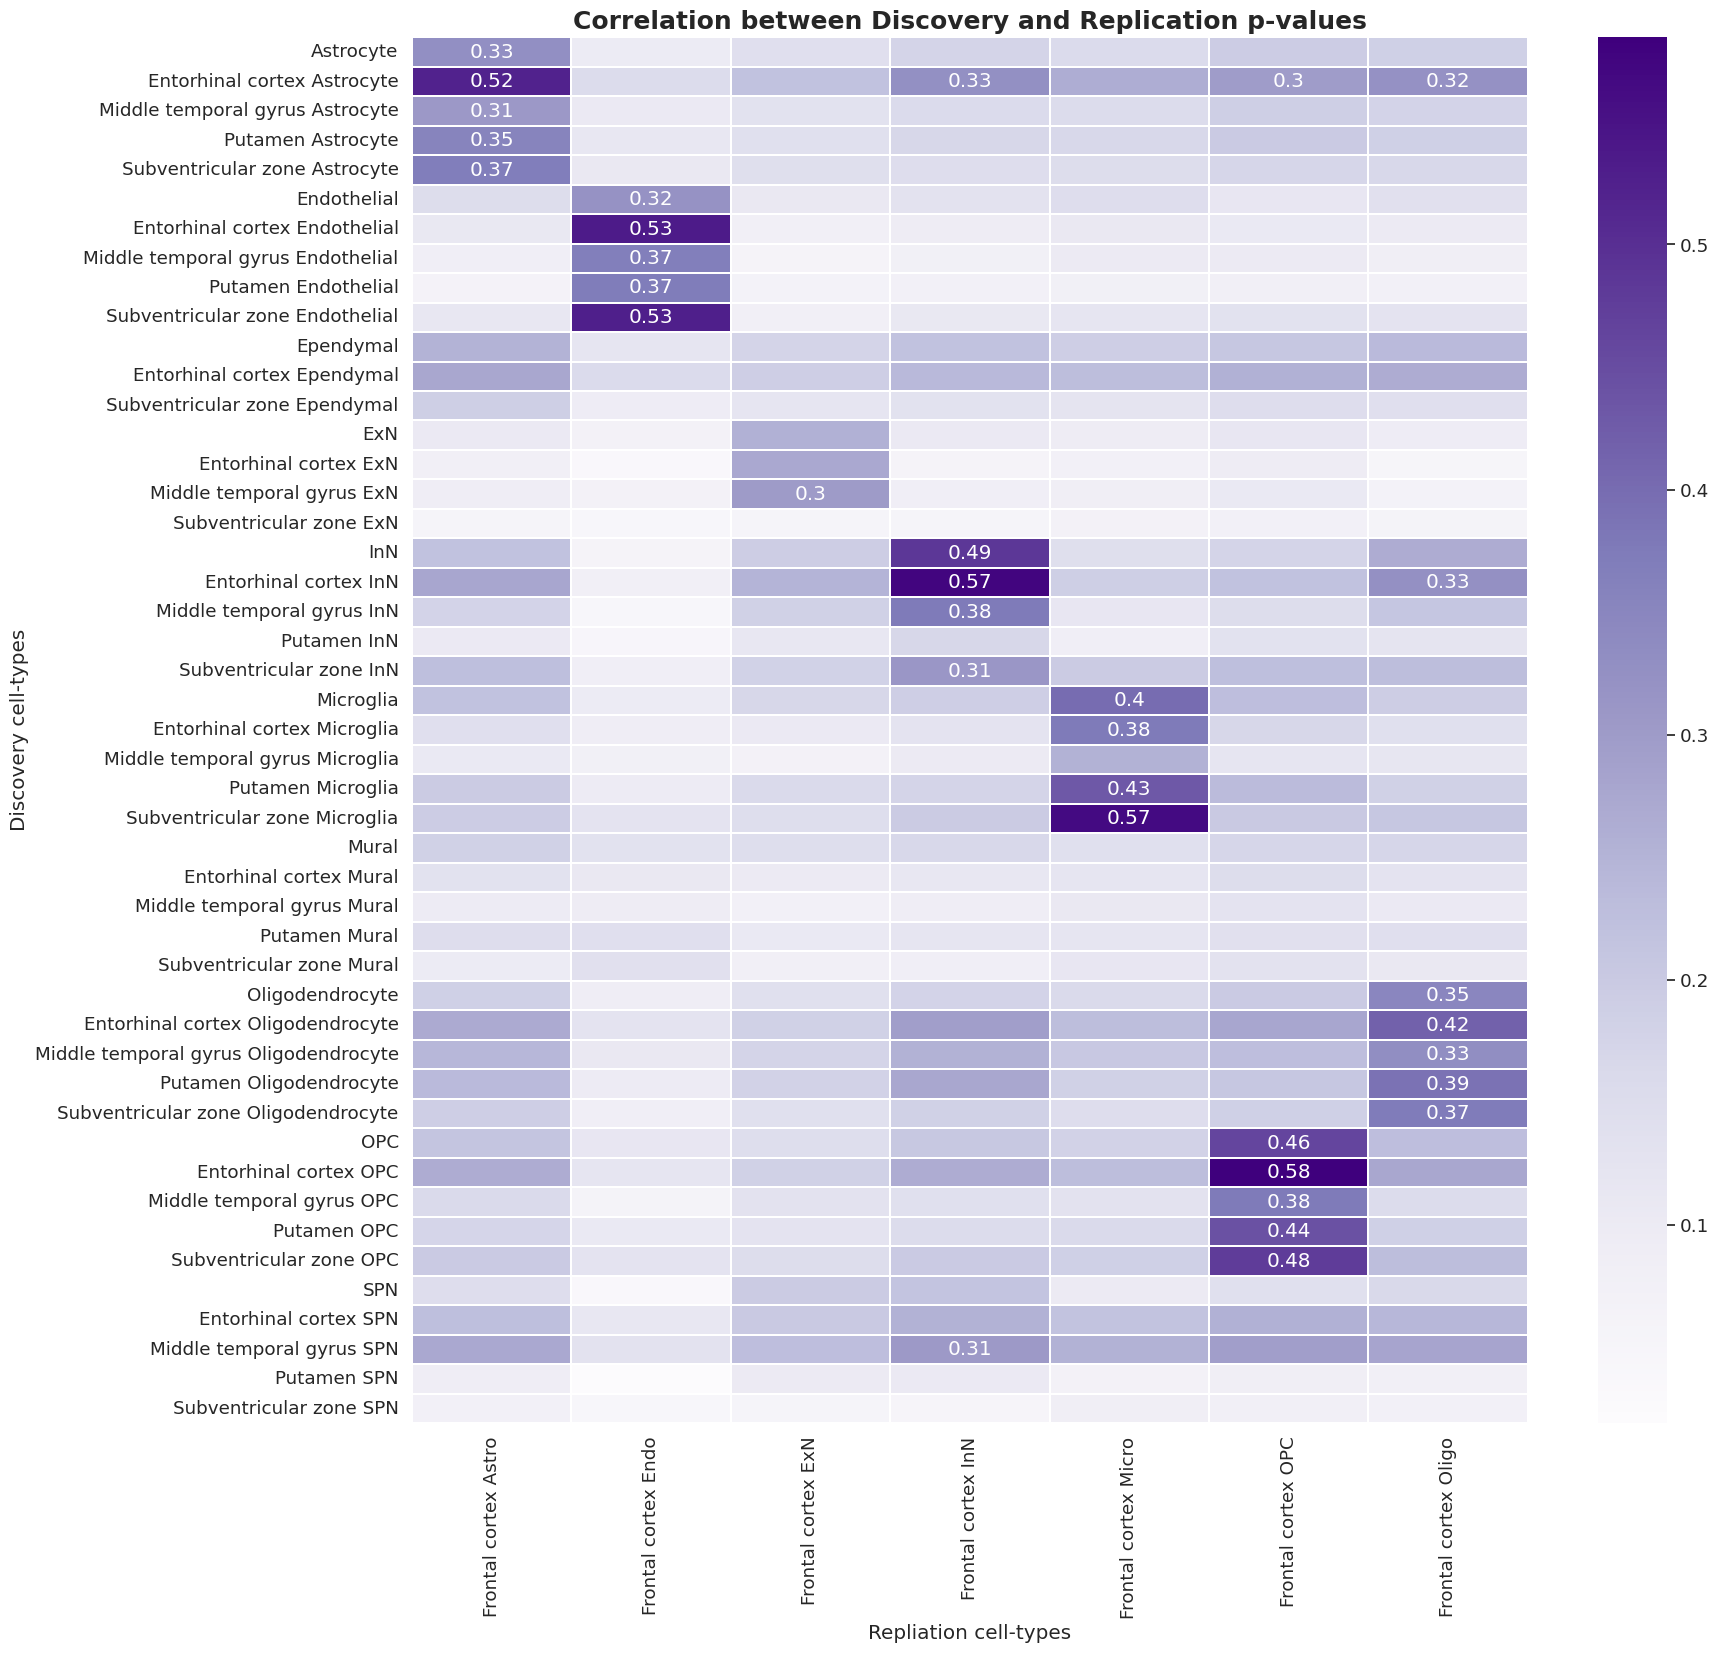

shape of return dataframe (47, 7)


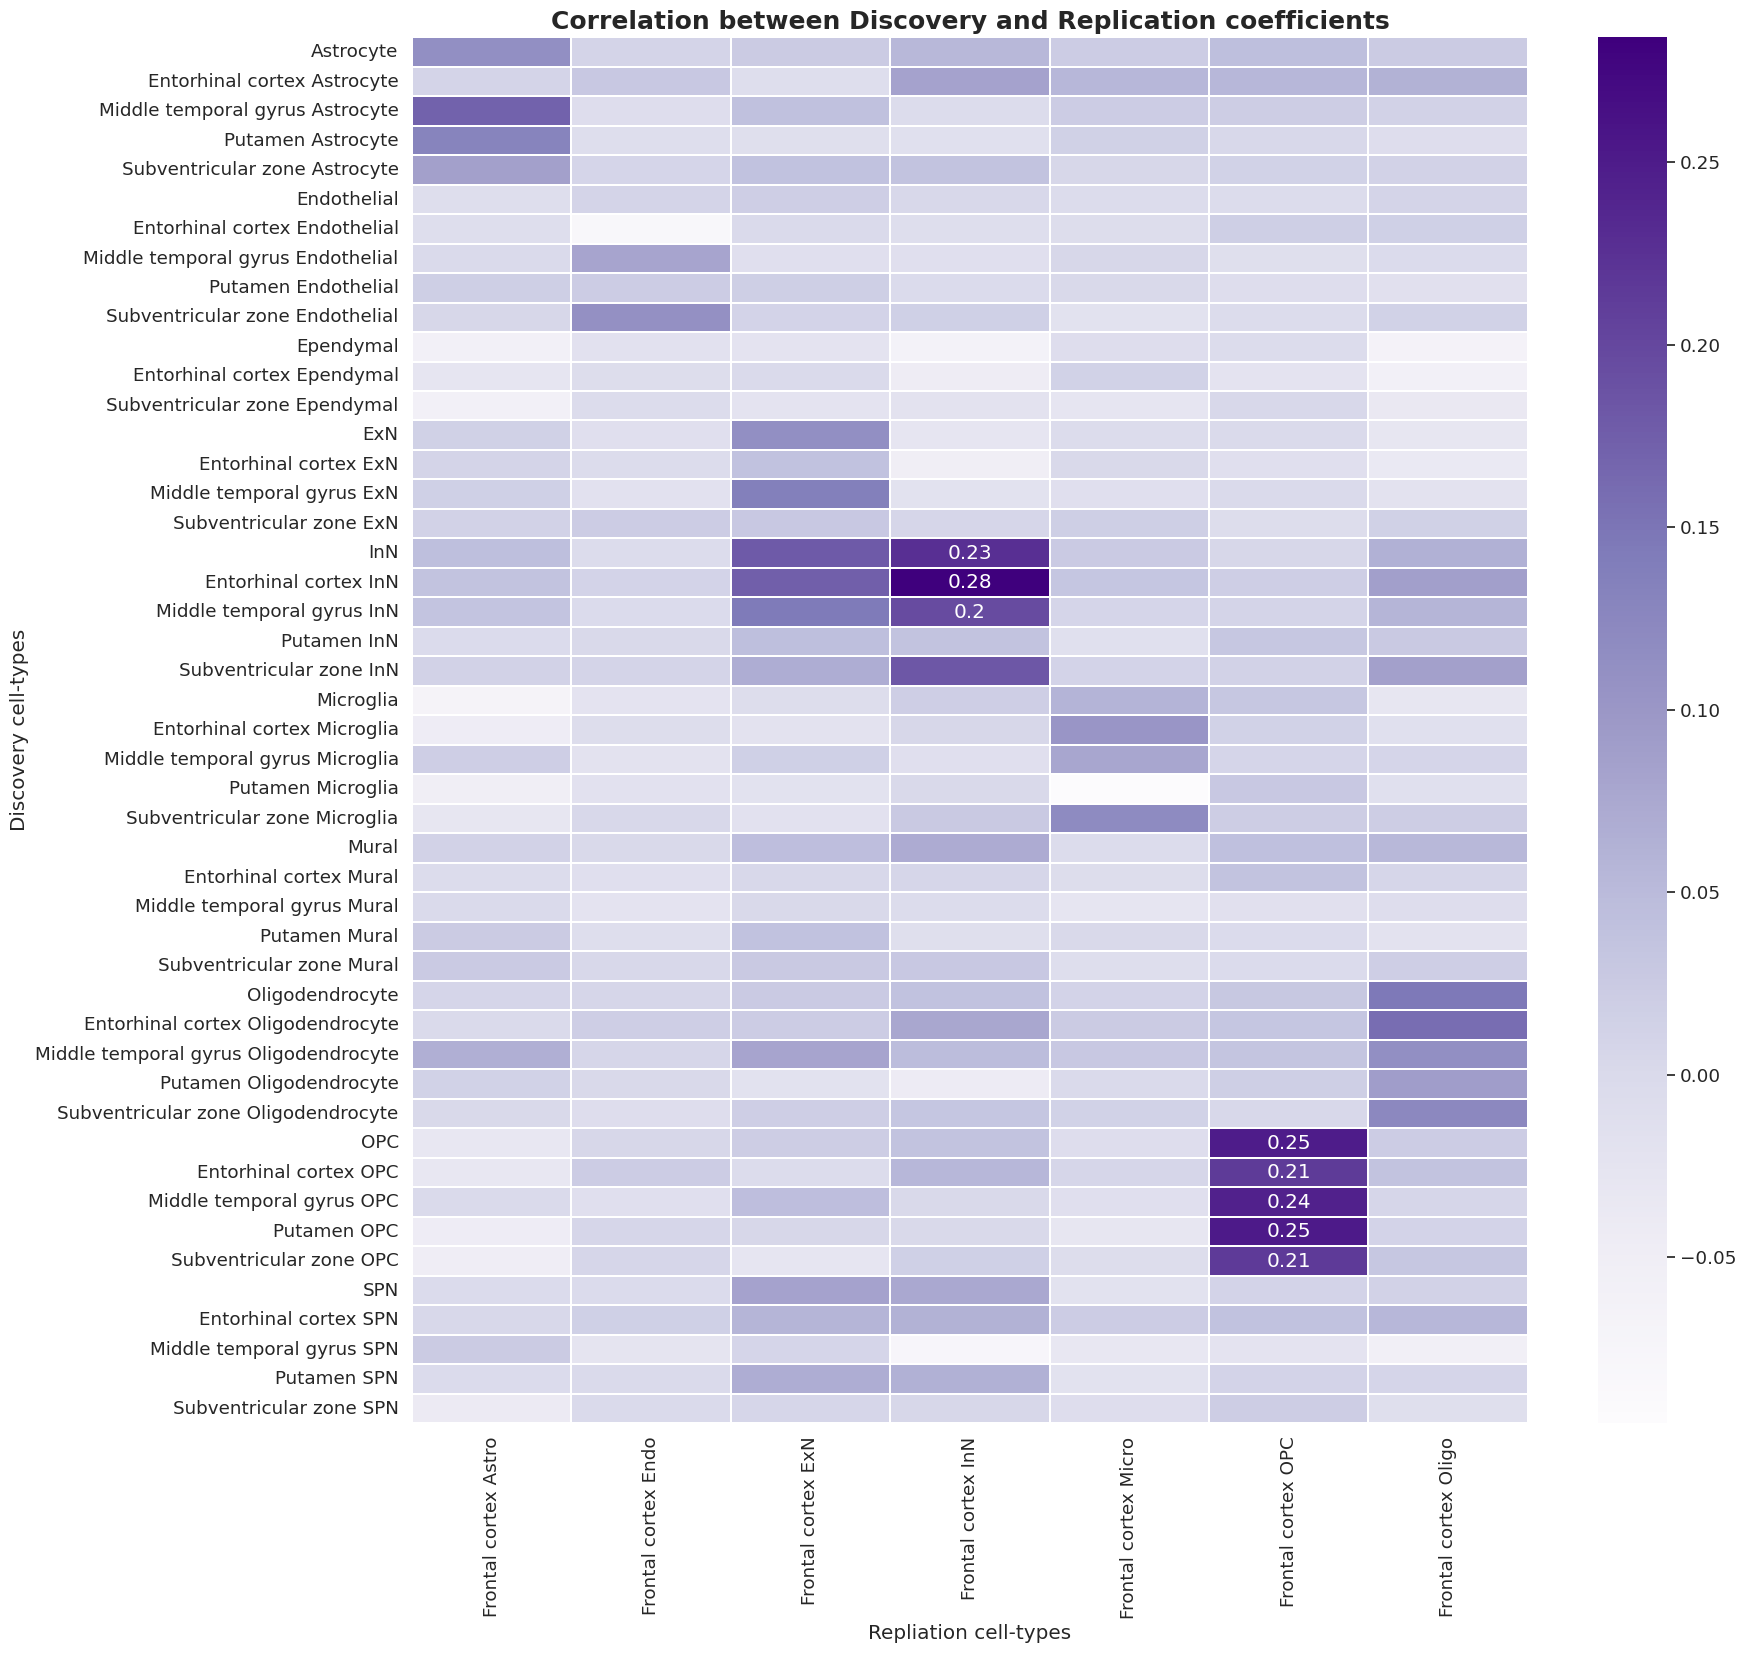

shape of return dataframe (47, 7)


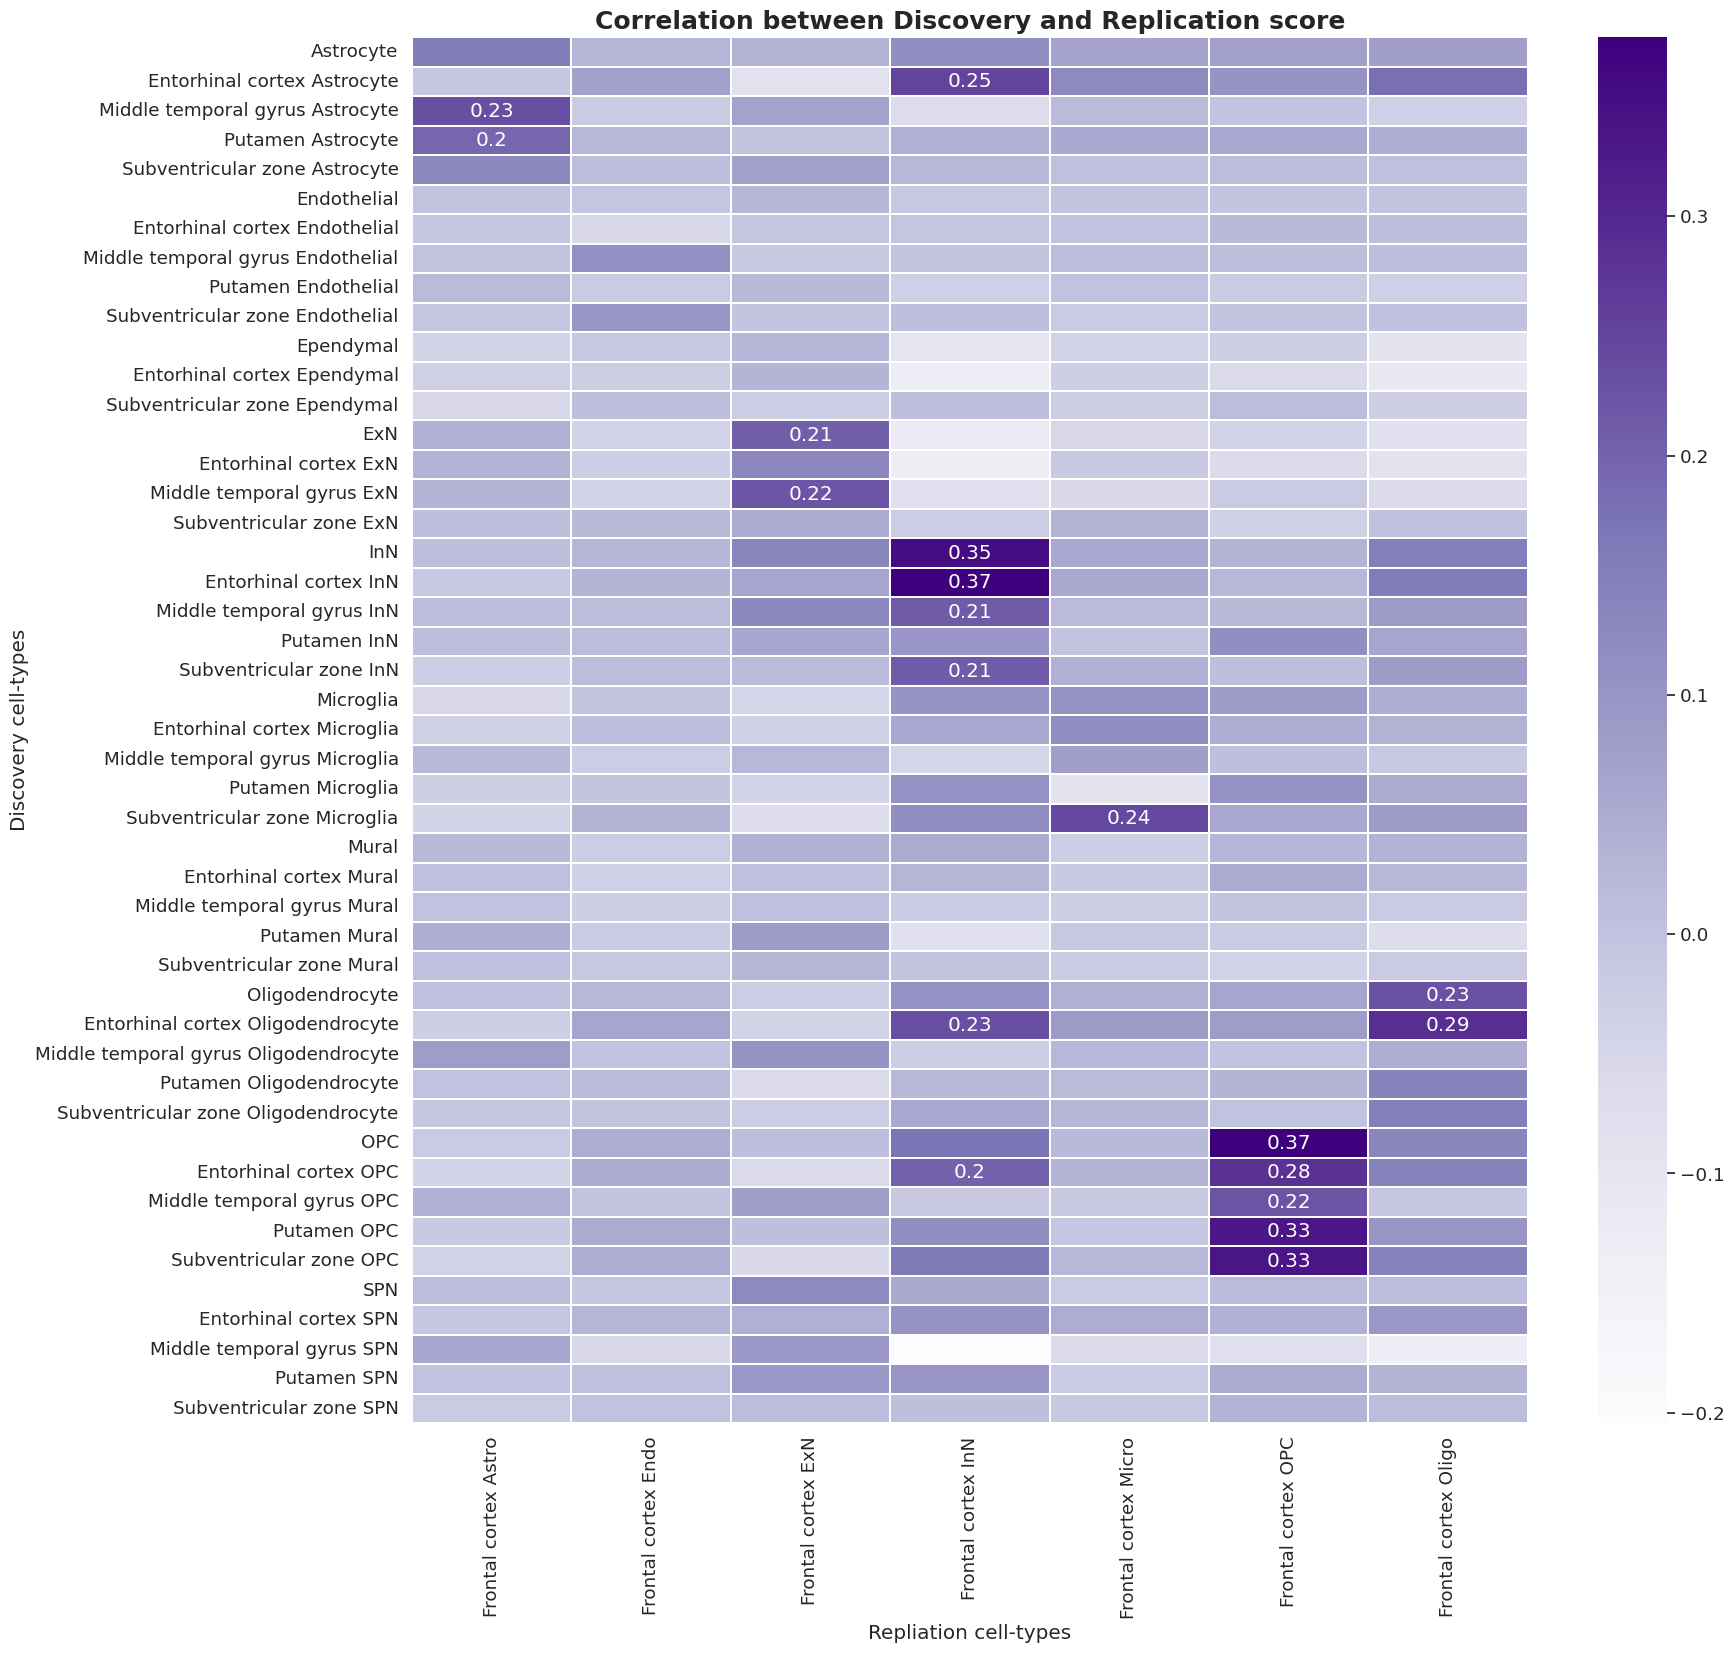

In [147]:
index_order = get_desired_index_order(disc_df)
# for p-values
corr_df = format_corr_df(pvalues_df)
visualize_correlations(corr_df, index_order, 'p-values')
# for coefficients
corr_df = format_corr_df(coef_df)
visualize_correlations(corr_df, index_order, 'coefficients', corr_min=0.2)
# for test statistic
corr_df = format_corr_df(scores_df)
visualize_correlations(corr_df, index_order, 'score', corr_min=0.2)

### model comparisons of results using GLM

In [175]:
disc_tissue_sig = disc_df.loc[(disc_df.tissue == endo_term) & (disc_df.fdr_bh < 0.05)]
print(disc_tissue_sig.shape)
display(disc_tissue_sig.head())

(945, 9)


,feature,intercept,estimate,std.error,statistic,p.value,tissue,type,fdr_bh
23968,ANKRD65,-3.232782,0.841059,0.231736,3.629388,0.000284,Astrocyte,broad_celltype,0.009591
23970,SLC35E2B,-0.634062,-0.346048,0.087407,-3.959062,0.000075,Astrocyte,broad_celltype,0.004147
23974,AL139246.5,-2.470412,-1.286258,0.360595,-3.567046,0.000361,Astrocyte,broad_celltype,0.011088
23979,CEP104,-0.317457,-0.231107,0.054400,-4.248263,0.000022,Astrocyte,broad_celltype,0.001825
23989,MIR34AHG,-2.769485,0.911708,0.221644,4.113392,0.000039,Astrocyte,broad_celltype,0.002705


In [187]:
sig_metric_df = coef_df[disc_tissue_sig.feature]
print(sig_metric_df.shape)
display(sig_metric_df.head())

(54, 945)


feature,ANKRD65,SLC35E2B,AL139246.5,CEP104,MIR34AHG,CLSTN1,UBIAD1,DISP3,AL021155.5,KAZN-AS1,...,VBP1,MT-CO2,MT-ATP8,MT-ND4L,MT-ND5,MT-ND6,MT-CYB,AL592183.1,AC240274.1,AC007325.2
tissue,,,,,,,,,,,,,,,,,,,,,
Astrocyte,0.841059,-0.346048,-1.286258,-0.231107,0.911708,-0.165675,-0.327779,-0.463879,0.767741,0.474821,...,-0.262587,-0.298756,-0.355802,-0.367056,-0.351370,-0.529696,-0.344134,-0.496069,-0.633798,0.617913
Endothelial,0.000000,0.000000,0.000000,0.000000,0.631028,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.155703,0.000000,0.000000,0.000000,0.000000,0.000000,-0.932348,0.000000
Entorhinal cortex Astrocyte,0.000000,-0.318559,0.000000,-0.446114,1.079879,-0.240819,-0.432502,-0.395149,0.000000,0.422861,...,-0.286585,-0.228935,-0.508496,-0.692868,-0.384235,-0.600632,-0.356637,-0.920388,-0.599976,0.724396
Entorhinal cortex Endothelial,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Entorhinal cortex Ependymal,0.000000,0.000000,0.000000,0.048347,0.000000,0.110003,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.272727,0.000000,0.083900,-0.246168,0.000000,-0.193689,-0.572265,0.000000,0.000000


In [194]:
model_in_df = DataFrame(data=[sig_metric_df.loc[exog_term], sig_metric_df.loc[endo_term]]).T
model_in_df.head()

,Frontal cortex InN,InN
feature,,
ANKRD65,0.000000,0.000000
SLC35E2B,-0.084047,-0.231372
AL139246.5,0.000000,-0.270666
CEP104,-0.070263,-0.061661
MIR34AHG,0.124153,0.114478


In [196]:
import statsmodels.api as sm
endo_term = 'InN'
exog_term = 'Frontal cortex InN'
X_exog = sm.add_constant(model_in_df[exog_term])
model = sm.GLM(model_in_df[endo_term], X_exog)
results = model.fit()
print(results.summary())
print(f'coef: {results.params[exog_term]}, p-value {results.pvalues[exog_term]}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    InN   No. Observations:                  945
Model:                            GLM   Df Residuals:                      943
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                        0.024281
Method:                          IRLS   Log-Likelihood:                 416.89
Date:                Fri, 05 Jan 2024   Deviance:                       22.897
Time:                        22:39:12   Pearson chi2:                     22.9
No. Iterations:                     3   Pseudo R-squ. (CS):            0.07781
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0714      0

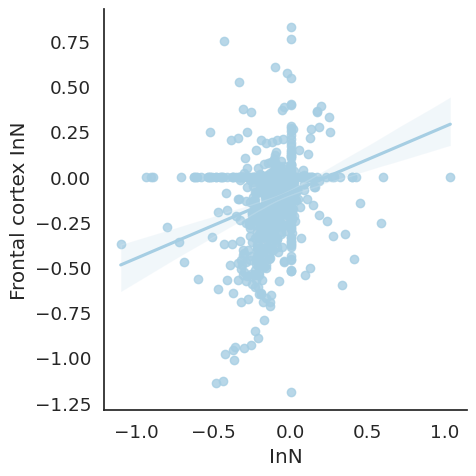

In [198]:
from seaborn import lmplot
lmplot(data=model_in_df, x=endo_term, y=exog_term)